In [1]:
# %%
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from load_data import *
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def inception_model(input_shape, num_classes, num_layers_to_freeze):
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    
    for layer in base_model.layers[:num_layers_to_freeze]:
        layer.trainable = False
    
    model = Sequential([
        Input(shape=input_shape),
        base_model,
        Flatten(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

In [3]:
def train_inception_model(X_train, y_train, X_eval, y_eval, num_classes, num_layers_to_freeze):
    IMAGE_SIZE = X_train.shape[1]
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    
    model = inception_model(input_shape, num_classes, num_layers_to_freeze)
    
    optimizer = Adam(learning_rate=0.0001)
    loss_fn = SparseCategoricalCrossentropy()
    metrics = ["accuracy"]
    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=metrics)
    
    batch_size = 20
    steps_per_epoch = len(X_train) // batch_size
    epochs = 15
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=(X_eval, y_eval),
        callbacks=[early_stopping]
    )
    
    return model, history, X_eval, y_eval

In [4]:
img_shape = (225, 225)

results = {
    "models": [],
    "histories": [],
    "X_eval": [],
    "y_eval_cat": []
}

# Train on Augmented Dataset
images, labels, label_map = load_dataset(img_shape[0], img_shape[0])
X_train_aug, y_train_aug, X_eval, y_eval, X_test, y_test = split_and_augment_dataset(images, labels, eval_set=True, random_state=42)

num_classes = len(label_map)
num_layers_to_freeze = 50
model_aug, history_aug, X_eval_aug, y_eval_cat_aug = train_inception_model(X_train_aug, y_train_aug, X_eval, y_eval, num_classes, num_layers_to_freeze)

results["models"].append(model_aug)
results["histories"].append(history_aug)
results["X_eval"].append(X_eval_aug)
results["y_eval_cat"].append(y_eval_cat_aug)

# Train on Non-Augmented Dataset
X_non_aug, y_non_aug, _ = load_dataset(img_shape[0], img_shape[0])
X_train_non_aug, X_temp, y_train_non_aug, y_temp = train_test_split(X_non_aug, y_non_aug, test_size=0.4, random_state=42)
X_test_non_aug, X_eval_non_aug, y_test_non_aug, y_eval_non_aug = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model_non_aug, history_non_aug, X_eval_non_aug, y_eval_cat_non_aug = train_inception_model(X_train_non_aug, y_train_non_aug, X_eval_non_aug, y_eval_non_aug, num_classes, num_layers_to_freeze)

results["models"].append(model_non_aug)
results["histories"].append(history_non_aug)
results["X_eval"].append(X_eval_non_aug)
results["y_eval_cat"].append(y_eval_cat_non_aug)


2023-11-01 14:34:08.947844: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-01 14:34:08.947874: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-01 14:34:08.947877: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-01 14:34:08.948058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-01 14:34:08.948076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/15


2023-11-01 14:34:14.635478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


567/567 [==============================] - 117s 196ms/step - loss: 0.7147 - accuracy: 0.7790 - val_loss: 0.3288 - val_accuracy: 0.9143
Epoch 2/15
567/567 [==============================] - 111s 195ms/step - loss: 0.2519 - accuracy: 0.9287 - val_loss: 0.2086 - val_accuracy: 0.9341
Epoch 3/15
567/567 [==============================] - 110s 194ms/step - loss: 0.1247 - accuracy: 0.9635 - val_loss: 0.3227 - val_accuracy: 0.9230
Epoch 4/15
567/567 [==============================] - 109s 193ms/step - loss: 0.0944 - accuracy: 0.9704 - val_loss: 0.3792 - val_accuracy: 0.9183
Epoch 5/15
567/567 [==============================] - 110s 194ms/step - loss: 0.0765 - accuracy: 0.9791 - val_loss: 0.3340 - val_accuracy: 0.9222
Epoch 6/15
567/567 [==============================] - 110s 195ms/step - loss: 0.0588 - accuracy: 0.9824 - val_loss: 0.1910 - val_accuracy: 0.9619
Epoch 7/15
567/567 [==============================] - 110s 193ms/step - loss: 0.0465 - accuracy: 0.9869 - val_loss: 0.1563 - val_accura

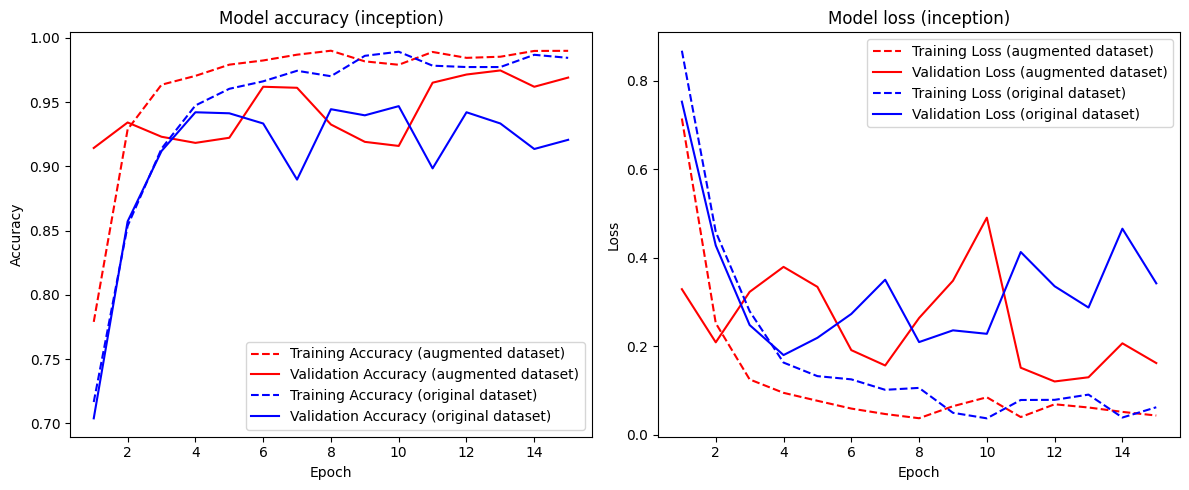

In [11]:
def plot_training_results(results):
    epochs = range(1, len(results["histories"][0].history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results["histories"][0].history['accuracy'], 'r--', label='Training Accuracy (augmented dataset)')
    plt.plot(epochs, results["histories"][0].history['val_accuracy'], 'r-', label='Validation Accuracy (augmented dataset)')
    plt.plot(epochs, results["histories"][1].history['accuracy'], 'b--', label='Training Accuracy (original dataset)')
    plt.plot(epochs, results["histories"][1].history['val_accuracy'], 'b-', label='Validation Accuracy (original dataset)')
    plt.title('Model accuracy (inception)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results["histories"][0].history['loss'], 'r--', label='Training Loss (augmented dataset)')
    plt.plot(epochs, results["histories"][0].history['val_loss'], 'r-', label='Validation Loss (augmented dataset)')
    plt.plot(epochs, results["histories"][1].history['loss'], 'b--', label='Training Loss (original dataset)')
    plt.plot(epochs, results["histories"][1].history['val_loss'], 'b-', label='Validation Loss (original dataset)')
    plt.title('Model loss (inception)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('img/inception_experiment_learning_curve.png', dpi=300)
    plt.show()

plot_training_results(results)


In [14]:
def evaluate_models(results):
    for i, (model, X_eval, y_eval_cat) in enumerate(zip(results["models"], results["X_eval"], results["y_eval_cat"])):
        loss, accuracy = model.evaluate(X_eval, y_eval_cat, verbose=0)
        print(f"Inception Model {i+1} ({'Without' if i % 2 else 'With'} Augmentation): Evaluation Loss: {loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")

evaluate_models(results)


Inception Model 1 (With Augmentation): Evaluation Loss: 0.1617, Evaluation Accuracy: 0.9690
Inception Model 2 (Without Augmentation): Evaluation Loss: 0.2279, Evaluation Accuracy: 0.9468


Now we can see that the data augmentation significantly improves Inception's accuracy, time to merge the train and eval and finally test on test

In [19]:
print("AUGMENTED DATASET RUN SHAPES: ")
print("X_train_aug shape:", X_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)
print("X_eval shape:", X_eval.shape)
print("y_eval shape:", y_eval.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


AUGMENTED DATASET RUN SHAPES: 
X_train_aug shape: (11340, 225, 225, 3)
y_train_aug shape: (11340,)
X_eval shape: (1260, 225, 225, 3)
y_eval shape: (1260,)
X_test shape: (1260, 225, 225, 3)
y_test shape: (1260,)


In [17]:
X_eval_augmented, y_eval_augmented = augment_data(X_eval, y_eval)

X_train_final = np.concatenate((X_train_aug, X_eval_augmented), axis=0)
y_train_final = np.concatenate((y_train_aug, y_eval_augmented), axis=0)

In [20]:
print("AUGMENTED DATASET RUN SHAPES: ")
print("X_train_final shape:", X_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


AUGMENTED DATASET RUN SHAPES: 
X_train_final shape: (15120, 225, 225, 3)
y_train_final shape: (15120,)
X_test shape: (1260, 225, 225, 3)
y_test shape: (1260,)


In [21]:
num_classes = len(np.unique(y_train_final))
num_layers_to_freeze = 50
model_full, history_full, _, _ = train_inception_model(X_train_final, y_train_final, X_test, y_test, num_classes, num_layers_to_freeze)

Epoch 1/15
756/756 [==============================] - 160s 200ms/step - loss: 0.5743 - accuracy: 0.8317 - val_loss: 0.2201 - val_accuracy: 0.9357
Epoch 2/15
756/756 [==============================] - 145s 192ms/step - loss: 0.1562 - accuracy: 0.9546 - val_loss: 0.2345 - val_accuracy: 0.9310
Epoch 3/15
756/756 [==============================] - 145s 191ms/step - loss: 0.0938 - accuracy: 0.9718 - val_loss: 0.1283 - val_accuracy: 0.9643
Epoch 4/15
756/756 [==============================] - 145s 192ms/step - loss: 0.1034 - accuracy: 0.9726 - val_loss: 0.2134 - val_accuracy: 0.9563
Epoch 5/15
756/756 [==============================] - 146s 193ms/step - loss: 0.0532 - accuracy: 0.9841 - val_loss: 0.1202 - val_accuracy: 0.9675
Epoch 6/15
756/756 [==============================] - 144s 191ms/step - loss: 0.0379 - accuracy: 0.9901 - val_loss: 0.2319 - val_accuracy: 0.9444
Epoch 7/15
756/756 [==============================] - 146s 193ms/step - loss: 0.0670 - accuracy: 0.9810 - val_loss: 0.1742 -

In [22]:
loss, accuracy = model_full.evaluate(X_test, y_test)
print("FINAL RUN - INCEPTION MODEL (AUGMENTED DATASET)")
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)

40/40 [==============================] - 8s 158ms/step - loss: 0.0626 - accuracy: 0.9810
FINAL RUN - INCEPTION MODEL (AUGMENTED DATASET)
Evaluation Loss: 0.062626414000988
Evaluation Accuracy: 0.9809523820877075


In [24]:
import os
import json

save_dir = "final_results/Inception"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model
model_save_path = os.path.join(save_dir, "model_inception.h5")
model_full.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save the history
history_save_path = os.path.join(save_dir, "history_inception.json")
with open(history_save_path, 'w') as f:
    json.dump(history_full.history, f)
print(f"Training history saved to {history_save_path}")

/Users/franekl/venv-metal-tf/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to final_results/Inception/model_inception.h5
Training history saved to final_results/Inception/history_inception.json


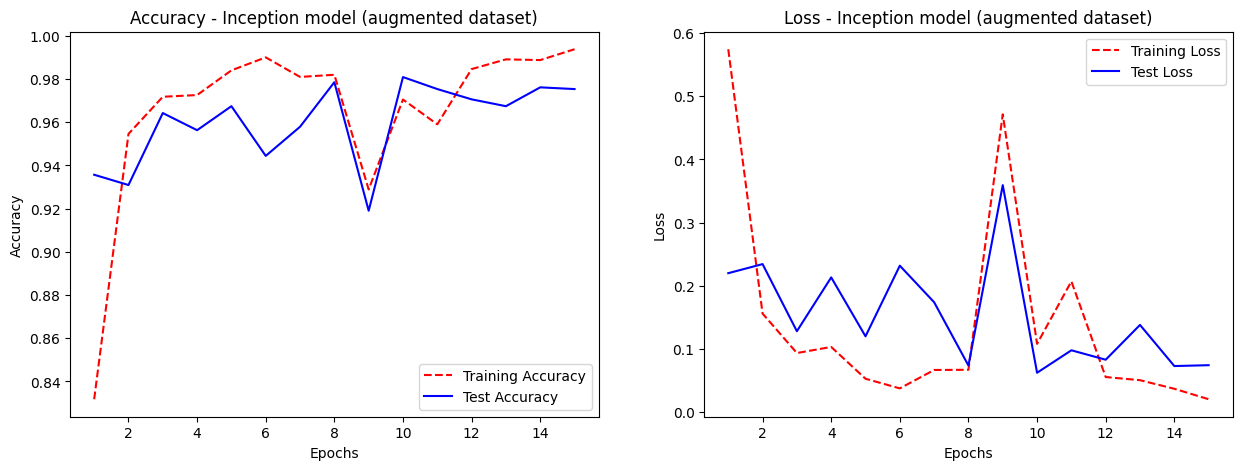

In [27]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_full.history['accuracy']) + 1)
train_loss = history_full.history['loss']
train_accuracy = history_full.history['accuracy']
test_loss = history_full.history.get('val_loss', None)
test_accuracy = history_full.history.get('val_accuracy', None)

# Creating subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and test accuracy
ax1.plot(epochs, train_accuracy, 'r--', label='Training Accuracy')
if test_accuracy is not None:
    ax1.plot(epochs, test_accuracy, 'b-', label='Test Accuracy')
ax1.set_title('Accuracy - Inception model (augmented dataset)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting training and test loss
ax2.plot(epochs, train_loss, 'r--', label='Training Loss')
if test_loss is not None:
    ax2.plot(epochs, test_loss, 'b-', label='Test Loss')
ax2.set_title('Loss - Inception model (augmented dataset)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.savefig('img/inception_final_learning_curve.png', dpi=300)
plt.show()


40/40 [==============================] - 7s 141ms/step


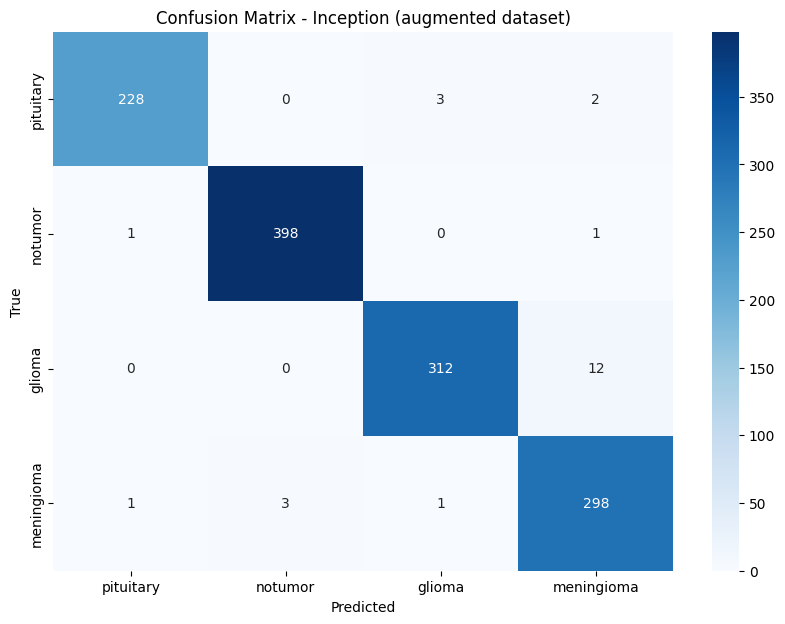

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Make predictions on the test set
y_pred = model_full.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reverse the label map to get a mapping from index to class name
index_to_class_name = {v: k for k, v in label_map.items()}

# Convert class indices to class names
y_test_names = np.vectorize(index_to_class_name.get)(y_test)
y_pred_classes_names = np.vectorize(index_to_class_name.get)(y_pred_classes)

# Compute the confusion matrix
cm = confusion_matrix(y_test_names, y_pred_classes_names, labels=list(label_map.keys()))

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix - Inception (augmented dataset)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('img/inception_final_confusion_matrix.png', dpi=300)
plt.show()

In [31]:
print('Classification Report (INCEPTION MODEL):\n', classification_report(y_test, y_pred_classes))


Classification Report (INCEPTION MODEL):
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       233
           1       0.99      0.99      0.99       400
           2       0.99      0.96      0.97       324
           3       0.95      0.98      0.97       303

    accuracy                           0.98      1260
   macro avg       0.98      0.98      0.98      1260
weighted avg       0.98      0.98      0.98      1260



In [30]:
print("Once again...\nFINAL RUN - INCEPTION MODEL (AUGMENTED DATASET)")
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)

Once again...
FINAL RUN - INCEPTION MODEL (AUGMENTED DATASET)
Evaluation Loss: 0.062626414000988
Evaluation Accuracy: 0.9809523820877075
